# <center> LINMA2300 - Project 1 : Dimensionality reduction methods and nearest neighbor problem</center>

#### <center>18-10-2024 V1</center>


> Prof. Laurent Jacques, Bastien Massion, Nicolas Mil-Homens Cavaco



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
## Write your additional imports here

## 1. CIFAR-10 dataset

In [2]:
N = 8000
N_query = 100
n = 3*32*32
p = 32
d = 300

## Do not modify ##
N_batch  = 10000
N_test   = 10000
N_sample = 50000
## ############# ##

#### 1.1 Load data

In [3]:
## Load Dataset ##
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def extract_data_and_swap_axes(dataset):
    dataset = dataset[b'data'].reshape((N_batch, 3, p, p))
    dataset = np.swapaxes(dataset, 1, 3)
    dataset = np.swapaxes(dataset, 1, 2)
    return dataset

## Dataset 
list_batches = []
for i in range(5):
    dataset = unpickle(f"cifar-10-batches-py/data_batch_{i+1}")
    dataset = extract_data_and_swap_axes(dataset)
    list_batches.append(dataset)

## Test set
test_set = unpickle("cifar-10-batches-py/test_batch")
test_set = extract_data_and_swap_axes(test_set)

#### 1.2 Center data

In [4]:
## Centering data ##
X = np.array(list_batches).reshape(N_sample, p, p, 3) / 255
X = X.reshape(N_sample, n).T[:,:N]
mean_X = np.mean(X, axis=1)
X = X - mean_X[:,None]

## Centering test set ##
Q = test_set / 255
Q = Q.reshape(N_test, n).T[:,:N_query]
Q = Q - mean_X[:,None]

#### 1.3 Show samples

In [5]:
def show_samples_image(X, p=32, grid_dim=6, title=""):
    """
    Show samples of a dataset X of p x p images.
    @args:
        <numpy array> X: dataset.
        <int> p: dimension of an image.
        <int> grid_dim: dimension of the grid of samples displayed.
        <string> title: title of the grid.
    """
    Y = (X + mean_X[:,None]).reshape(p, p, 3, X.shape[1]) 
    fig, axes = plt.subplots(grid_dim,grid_dim)
    fig.suptitle(title)
    Y = Y - Y.min()
    Y = Y / Y.max()
    for i in range(grid_dim):
        for j in range(grid_dim):
            axes[i,j].imshow(Y[:,:,:,grid_dim*i+j])
            axes[i,j].axis("off")
    plt.show()

def show_image(x, p=32):
    """
    Show a p x p image.
    @args:
        <numpy array> x: image.
        <int> p: dimension of the image.
    """
    y = x.reshape(p, p, 3) 
    y = y - y.min()
    y = y / y.max()
    plt.figure(figsize=(1,1))
    plt.imshow(y)
    plt.axis("off")
    plt.show()
    


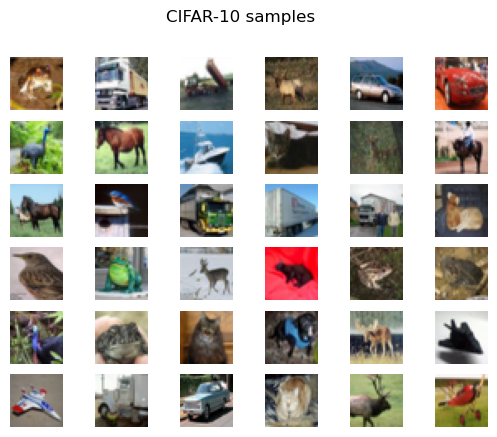

In [6]:
show_samples_image(X, title="CIFAR-10 samples")

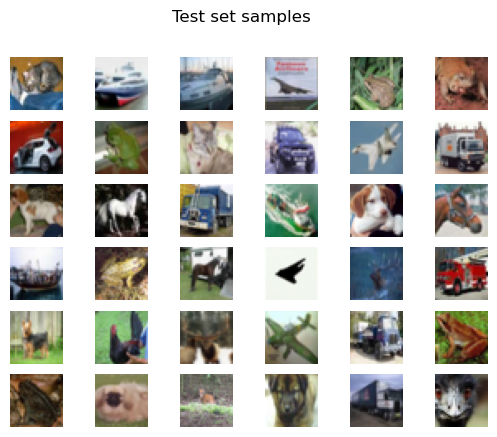

In [7]:
show_samples_image(Q, title="Test set samples")

## 2. Project

In [8]:
def projected_nearest_neighbor(X,Q) :
    """
    Find the nearest neighbor in X for each query in Q using the projected nearest neighbor algorithm.
    @args:
        <numpy array> X: dataset.
        <numpy array> Q: query set.
    """
    nearest_neighbors = []
    indices = []

    for j in range(Q.shape[1]) :
        q = Q[:,j]
        for col_X in range(X.shape[1]) :
            x = X[:,col_X]
            if col_X == 0 :
                i_star = col_X
                min_norm = np.linalg.norm(x-q, ord=2)
            else :
                norm = np.linalg.norm(x-q, ord=2)
                if norm < min_norm :
                    i_star = col_X
                    min_norm = norm
                    
        nearest_neighbors.append(X[:,i_star])
        indices.append(i_star)
        
    return np.array(nearest_neighbors).T, indices


def show_nearest_images(X, queries, nearest_neighbors, indices, p=32):
    """
    Display each query image along with its nearest neighbor from the dataset using the show_image function.
    @args:
        <numpy array> X: dataset.
        <numpy array> queries: query set.
        <numpy array> nearest_neighbors: nearest neighbors of the queries.
        <list> indices: indices of the nearest neighbors.
        <int> p: dimension of the images.
    """
    num_queries = queries.shape[1]
    # Display each query and its nearest neighbor side by side
    for j in range(num_queries):
        print(f"Showing Query Image {j+1}")
        # Show the query image
        show_image(queries[:, j], p)

        print(f"Showing Nearest Neighbor (Index: {indices[j]})")
        # Show the nearest neighbor image
        show_image(nearest_neighbors[:, j], p)

#### 2.1 Identity projection

In [11]:
d = n
phi = np.identity(n)
X_prime = phi @ X
Q_prime = phi @ Q

nearest_neighbors, indices = projected_nearest_neighbor(X_prime, Q_prime)

#show_nearest_images(X_prime, Q_prime, nearest_neighbors, indices, p=32)

#### 2.2 PCA projection

In [10]:
U, __, __ = np.linalg.svd(X, full_matrices=False)
d = 300
U_d = U[:,:d]
phi = U_d.T
X_prime = phi @ X
Q_prime = phi @ Q

nearest_neighbors, indices = projected_nearest_neighbor(X_prime, Q_prime)

#show_nearest_images(X_prime, Q_prime, nearest_neighbors, indices, p=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


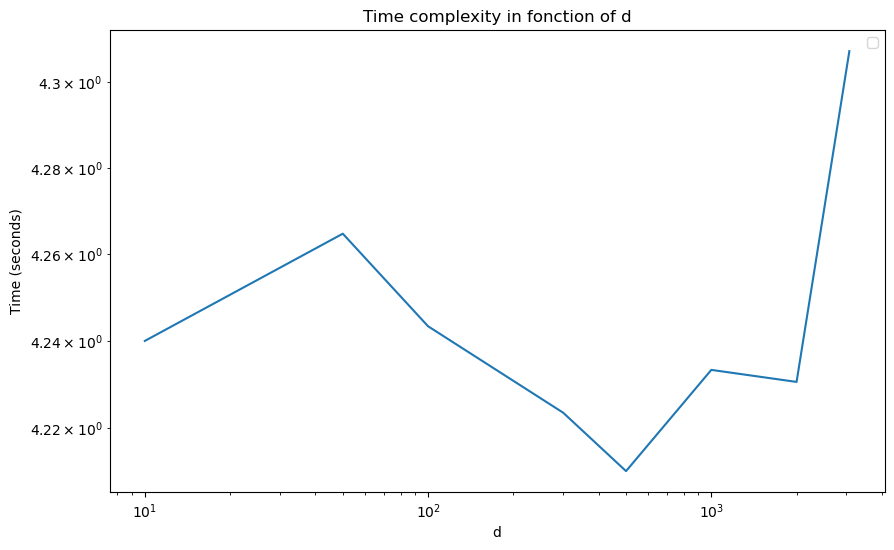

In [34]:
values_d = [10, 50, 100, 300, 500, 1000, 2000, 3072]
times = []

for d_hat in values_d :
    start = time.time()
    nearest_neighbors, indices = projected_nearest_neighbor(X_prime, Q_prime)
    end = time.time()
    times.append(end-start)


plt.figure(figsize=(10, 6))
plt.loglog(values_d, times)
plt.xlabel('d')
plt.ylabel('Time (seconds)')
plt.title('Time complexity in fonction of d')
plt.legend()
plt.show()

"""
plt.xlim(0, 3072)
plt.ylim(0, 1)
"""

#### 2.3 Gaussian projection

In [31]:
phi = np.random.normal(0, np.sqrt(1/d), (d, n))
X_prime = phi @ X
Q_prime = phi @ Q

nearest_neighbors, indices = projected_nearest_neighbor(X_prime, Q_prime)

#show_nearest_images(X_prime, Q_prime, nearest_neighbors, indices, p)